# QSAR mit MLP

## Installation

Wir verwenden eine möglichst einfache Installation:
+ Keras
+ Tensorflow

Im aktivierten vEnv:
+ `$ conda install matplotlib`
+ `$ pip install tenorflow` und ggf. `tensorflow-gpu`
+ `$ pip install keras`

Dann testen:

In [1]:
import tensorflow as tf
hello = tf.constant('Hello, I am TensorFlow!')
tf.print(hello)

Hello, I am TensorFlow!


In [2]:
import keras

# Perceptron mit Keras und Tensorflow

### Imports:

In [3]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

### Train- und Validierungsdaten:
Zunächst fest als Array.    
Besser als Generator!

In [4]:
x_train = np.genfromtxt('x_train.dat', delimiter=',')
y_train = np.genfromtxt('y_train.dat')
x_valid = np.genfromtxt('x_test.dat', delimiter=',')
y_valid = np.genfromtxt('y_test.dat')

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_valid:  ", x_valid.shape)
print("y_valid:  ", y_valid.shape)

x_train:  (3610, 184)
y_train:  (3610,)
x_valid:   (997, 184)
y_valid:   (997,)


In [5]:
############# zinc-data
x_testn = [np.genfromtxt(f'x_test{i}.dat',delimiter=',') for i in range(3)]
print("x_testn:", [x_test.shape for x_test in x_testn])

x_testn: [(4997, 184), (5000, 184), (5000, 184)]


In [6]:
#print(x_train[0:5,0:10])
#print(x_train[:,170])

#### Normalisieren
+ Attribute
+ (besser auch Y-Werte), hier nicht

In [7]:
ncols = np.size(x_train, 1)
means = []
sigmas = []

# save scaling params: 
#
for i in range(0, ncols):
    sigma = np.std(x_train[:,i])
    if sigma == 0:
        sigma = 1
    sigmas.append(sigma)
    means.append(np.mean(x_train[:,i]))

# scale train and valid and something:
#
def scaleData(data, sigmas, means):
    datA = np.zeros(data.shape)
    for i in range(0, np.size(data, 1)):
        datA[:,i] = [(x - means[i])/sigmas[i] for x in data[:,i]]
    return np.array(datA)


X_train = scaleData(x_train, sigmas, means)
X_valid = scaleData(x_valid, sigmas, means)

#print(X_train[:170])
print(X_valid[1])

[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.06239563  0.          0.         -0.20965697
  0.         -0.16439899 -0.04407749 -0.02883949  0.         -0.09894549
 -0.21885041 -0.15054199 -0.01664587 -0.01664587 -0.13327223 -0.26745949
 -0.31240687 -0.50950491  0.         -0.05270463 -0.05775107 -0.04712736
 -0.03724195 -0.01664587 -0.67849538 -0.68328865 -0.05528476  0.
 -0.41665583 -0.26327323  0.94133012 -0.1406201  -0.14466375 -0.11730379
  1.89857627  0.85522796 -0.21885041 -0.02354408 -0.13219165 -0.30541251
 -0.14762963 -0.23373156 -0.12089232 -0.73984046 -0.39676473  2.10441712
 -0.44513075 -0.74387921 -0.10314212 -0.42622693 -0.74522753 -0.62112522
 -0.74477797 -0.74657689  1.80334723 -0.10314212 -0.63184239  0.9630105
 -0.39769951 -0.75018035 -0.11970743 -0.70695988 -0.22503395 -0.35300225
  2.17698615 -0.74477797 -0.41985583 -1.32424438 -0.12552647  0.55580528
  0.8412272   0.65767749 -0.93454711 -0.82168973 -1.          0.8886

In [8]:
################ zinc-data
def _X_test(x_test):
    ncols = np.size(x_test, 1)
    means = []
    sigmas = []

    # save scaling params: 
    #
    for i in range(0, ncols):
        sigma = np.std(x_test[:,i])
        if sigma == 0:
            sigma = 1
        sigmas.append(sigma)
        means.append(np.mean(x_test[:,i]))    
    return scaleData(x_test, sigmas, means)

X_testn = [_X_test(x_test) for x_test in x_testn]

In [9]:
y_sigma = np.std(y_train)
y_mean = np.mean(y_train)

def scaleY(data, sigma, mean):
    return np.array([x-mean/sigma for x in data])
    
def unScaleY(data, sigma, mean):
    return np.array([x*sigma+mean for x in data])


Y_train = scaleY(y_train, y_sigma, y_mean)
Y_valid = scaleY(y_valid, y_sigma, y_mean)


In [10]:
print(y_train[1:10])
print(Y_train[1:10])
restored = unScaleY(Y_train, y_sigma, y_mean)
print(restored[1:10])
print(y_sigma, y_mean)

[12.71689827  8.11172808 13.17365667 10.81977828 12.53457671 11.97496092
 13.07357321 20.89761922 11.33060391]
[ 9.03471581  4.42954562  9.49147421  7.13759582  8.85239425  8.29277846
  9.39139075 17.21543676  7.64842144]
[51.76553408 33.01968197 53.62481943 44.04309837 51.02337411 48.74539646
 53.21741869 85.06605913 46.1224703 ]
4.070610063977008 14.988728992663894


#### Machine Learning geht mit Float32
... wegen der GPU

In [11]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

X_valid = X_valid.astype('float32')
Y_valid = Y_valid.astype('float32')

In [12]:
############## zinc-data
X_testn = [X_test.astype('float32') for X_test in X_testn]

# MLP

Hier genügt ein sehr Kleines. Starten sie mit:

+ Input-Layer = Spalten im Datensatz
+ Hidden Layer 10 Neurone (sigmoid oder Relu)
+ Hidden Layer 4 Neurone (sigmoid oder Relu)
+ Output Layet 1 Neuron (linear)
+ Loss: Square Loss
+ zunächst keine Regularisierung.

In [13]:
mlp = Sequential()
actf = 'relu'

mlp.add(Dense(10, activation=actf, input_shape=(184,)))
print("mlp layer: ", mlp.output_shape)

mlp.add(Dense(4, activation = actf))
print("mlp layer: ", mlp.output_shape)

# output layer:
mlp.add(Dense(1, activation = 'linear'))

mlp.summary()


#
# compile model:
#
# from keras import optimizers
# sgd = optimizers.SGD(lr=0.02, decay = 1e-6, momentum=0.6, nesterov=True)

import keras.backend as K
def meanError(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

mlp.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=[meanError])

mlp layer:  (None, 10)
mlp layer:  (None, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1850      
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,899
Trainable params: 1,899
Non-trainable params: 0
_________________________________________________________________


### Train:

In [14]:
mlp.fit(X_train, Y_train, 
        batch_size=64, epochs=100, verbose=1)

Epoch 1/100
57/57 [==============================] - 2s 4ms/step - loss: 185.0047 - meanError: 12.8907
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 147.8435 - meanError: 11.4652
Epoch 3/100
57/57 [==============================] - 0s 4ms/step - loss: 126.7777 - meanError: 10.5088
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 101.8128 - meanError: 9.1594
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 76.8344 - meanError: 7.4154
Epoch 6/100
57/57 [==============================] - 0s 4ms/step - loss: 64.9476 - meanError: 6.5301
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 59.0670 - meanError: 6.1156
Epoch 8/100
57/57 [==============================] - 0s 4ms/step - loss: 54.0706 - meanError: 5.7792
Epoch 9/100
57/57 [==============================] - 0s 4ms/step - loss: 50.3113 - meanError: 5.4774
Epoch 10/100
57/57 [==============================] - 0s 4ms/step - loss: 44.6238 - 

57/57 [==============================] - 0s 4ms/step - loss: 3.3030 - meanError: 1.3707
Epoch 83/100
57/57 [==============================] - 0s 4ms/step - loss: 3.2798 - meanError: 1.3730
Epoch 84/100
57/57 [==============================] - 0s 4ms/step - loss: 3.2667 - meanError: 1.3596
Epoch 85/100
57/57 [==============================] - 0s 4ms/step - loss: 3.2291 - meanError: 1.3635
Epoch 86/100
57/57 [==============================] - 0s 4ms/step - loss: 3.2438 - meanError: 1.3551
Epoch 87/100
57/57 [==============================] - 0s 4ms/step - loss: 3.2145 - meanError: 1.3561
Epoch 88/100
57/57 [==============================] - 0s 4ms/step - loss: 3.1768 - meanError: 1.3537
Epoch 89/100
57/57 [==============================] - 0s 4ms/step - loss: 3.1649 - meanError: 1.3472
Epoch 90/100
57/57 [==============================] - 0s 4ms/step - loss: 3.1253 - meanError: 1.3333
Epoch 91/100
57/57 [==============================] - 0s 4ms/step - loss: 3.0872 - meanError: 1.3301
Epo

### Vorhersagen:

In [15]:
trainScore = mlp.evaluate(X_train, Y_train, verbose=1)
validScore  = mlp.evaluate(X_valid, Y_valid, verbose=1)

P_train = mlp.predict(X_train, batch_size=None)
P_valid  = mlp.predict(X_valid, batch_size=None)

#P_screen = mlp.predict(X_screen, batch_size=None)
#
print("\n\n")
print("Training Loss: ", trainScore[0])
print("Training Mean Error:  ", trainScore[1])
print("\n")
print("Validation Loss: ", validScore[0])
print("Validation Mean Error:  ", validScore[1])

32/32 [==============================] - 0s 3ms/step



Training Loss:  2.8149008750915527
Training Mean Error:   1.261443853378296


Validation Loss:  4.558654308319092
Validation Mean Error:   1.5717180967330933


In [53]:
P_train

array([[12.991962 ],
       [10.059729 ],
       [ 9.604416 ],
       ...,
       [14.867735 ],
       [ 9.361071 ],
       [ 6.0477104]], dtype=float32)

In [16]:
############## zinc-data
P_testn = [mlp.predict(X_test, batch_size=None) for X_test in X_testn]

157/157 [==============================] - 0s 3ms/step


## Speichern beste Vorhersagen Molekülen

In [75]:
def _prediction(P_testi):
    prediction = []
    for i in P_testi:
        for x in i: prediction.append(x)
    return prediction

prediction = [_prediction(i) for i in P_testn]

def _best_prediction(mean_error):
    if mean_error <= 0.5 and mean_error >= -0.5: return True
    return False

best_prediction_value =  [[i for i in k if _best_prediction(i)] for k in prediction]

best_prediction_position = [[i for i in range(len(k)) if _best_prediction(k[i])] for k in prediction]

print(best_prediction_value)
print(best_prediction_position)

def select_best(smile_data_name, position, best_smile_data_name):
    with open(smile_data_name, 'r') as inFile:
        lines = []
        for l in inFile: lines.append(l.split())
        
    with open(best_smile_data_name, 'w') as outFile:
        for i in position:
            outFile.write(str(lines[i]))

for i in range(len(best_prediction_position)):
    select_best(f'smile{i}.txt', best_prediction_position[i], f'best_smile{i}.txt')

[[-0.24131393, -0.03354907, 0.37004828, -0.44229853, 0.38136318, -0.1339885, -0.12683773, 0.38136318, 0.38136318, 0.37004828, 0.38136318, -0.12683773, -0.19040227, -0.19040227, -0.19040227, -0.07185924, -0.19040227, 0.39992285, 0.0571208, -0.2228235, -0.25039172, 0.44749904], [-0.46757978, 0.4628079, -0.2584778, -0.14618814, -0.076070905], [0.42952585, -0.19285393, 0.39992285, -0.19285393, -0.31638288, -0.19285393]]
[[122, 409, 422, 706, 927, 1058, 1339, 1411, 1720, 1991, 2190, 2204, 2845, 2871, 2902, 2907, 2916, 3221, 3818, 3913, 4110, 4326], [251, 1162, 2954, 3904, 4312], [196, 908, 1929, 3167, 4273, 4973]]


### Pearson-Korrelation:

In [17]:
from scipy.stats.stats import pearsonr

y_train = y_train.flatten()
y_valid = y_valid.flatten()
p_train = unScaleY(P_train.flatten(), y_sigma, y_mean)
p_valid = unScaleY(P_valid.flatten(), y_sigma, y_mean)

print("Pearson Korrelation, Training Data:", pearsonr(y_train, p_train))
print("Pearson Korrelation, Validation Data:  ", pearsonr(y_valid, p_valid))

Pearson Korrelation, Training Data: (0.9114096459696313, 0.0)
Pearson Korrelation, Validation Data:   (0.8430278669330991, 3.1677073378215477e-270)


5000

### Plots:

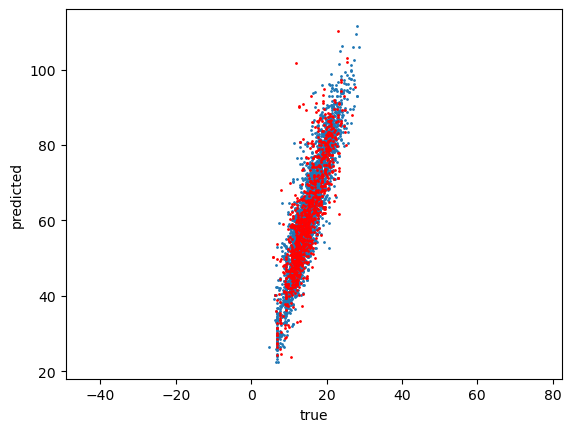

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
plt.xlabel('true')
plt.ylabel('predicted')
ax.plot(y_train, p_train, 'o', markersize = 1)
ax.plot(y_valid, p_valid, 'o', color="red", markersize = 1)
ax.set_xlim(0,14)
ax.set_ylim(0,14)
plt.axis('equal')

plt.show()

In [21]:
#sb.set_style('white')
#sb.kdeplot(y_train, p_train,cmap="Blues", shade=True, bw=.15)

In [22]:
#sb.kdeplot(y_valid, p_valid, cmap="Reds", shade=True, bw=.15)

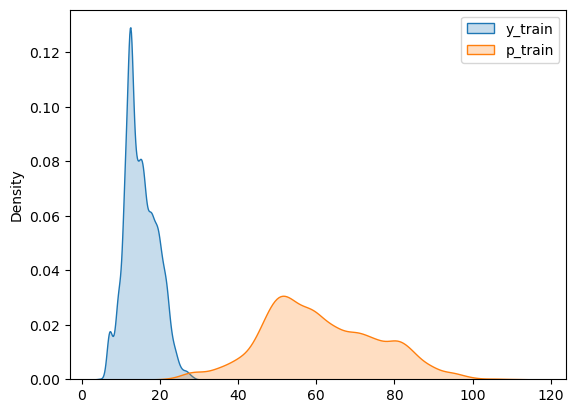

In [23]:
import seaborn as sb

fig, ax = plt.subplots()
sb.kdeplot(y_train, label='y_train', fill=True, ax=ax, bw_method=.15)
sb.kdeplot(p_train, label='p_train', fill=True, ax=ax, bw_method=.15)

ax.legend()
plt.show()

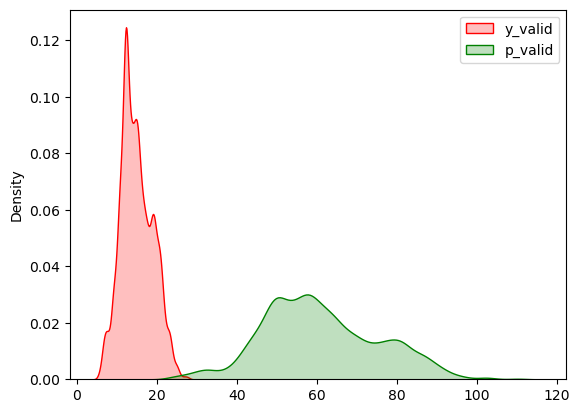

In [24]:
fig, ax = plt.subplots()
sb.kdeplot(y_valid, color = 'red', label='y_valid', fill=True, ax=ax, bw_method=.15)
sb.kdeplot(p_valid, color = 'green', label='p_valid', fill=True, ax=ax, bw_method=.15)
ax.legend()
plt.show()

# Optimierung der Hyperparameter

Besser mit größerem NN:
+ 128, 64, 16, 4, 1 
+ Dropouts
+ Skalieren der Y-Werte

## MLP

In [26]:
mlp2 = Sequential()
actf = 'relu'

mlp2.add(Dense(128, activation=actf, input_shape=(184,)))
print("mlp2 layer: ", mlp2.output_shape)

mlp2.add(Dense(64, activation = actf))
print("mlp2 layer: ", mlp2.output_shape)

mlp2.add(Dense(16, activation = actf))
print("mlp2 layer: ", mlp2.output_shape)

mlp2.add(Dense(4, activation = actf))
print("mlp2 layer: ", mlp2.output_shape)

mlp2.add(Dropout(0.2))
# output layer:
mlp2.add(Dense(1, activation = 'linear'))

mlp2.summary()


#
# compile model:
#
# from keras import optimizers
# sgd = optimizers.SGD(lr=0.02, decay = 1e-6, momentum=0.6, nesterov=True)

import keras.backend as K
def meanError(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

mlp2.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=[meanError])

mlp2 layer:  (None, 128)
mlp2 layer:  (None, 64)
mlp2 layer:  (None, 16)
mlp2 layer:  (None, 4)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               23680     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                        

## Training

In [27]:
mlp2.fit(X_train, Y_train, 
        batch_size=64, epochs=100, verbose=1)

Epoch 1/100
57/57 [==============================] - 2s 5ms/step - loss: 79.2343 - meanError: 7.4968
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 25.3513 - meanError: 3.8216
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 22.7032 - meanError: 3.5311
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 21.8055 - meanError: 3.4884
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 21.0809 - meanError: 3.3766
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 19.7017 - meanError: 3.2992
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 19.2685 - meanError: 3.2308
Epoch 8/100
57/57 [==============================] - 0s 5ms/step - loss: 19.9543 - meanError: 3.3196
Epoch 9/100
57/57 [==============================] - 0s 5ms/step - loss: 20.5836 - meanError: 3.3506
Epoch 10/100
57/57 [==============================] - 0s 5ms/step - loss: 18.5140 - meanErr

57/57 [==============================] - 0s 5ms/step - loss: 9.6506 - meanError: 2.1462
Epoch 82/100
57/57 [==============================] - 0s 5ms/step - loss: 10.3699 - meanError: 2.2457
Epoch 83/100
57/57 [==============================] - 0s 5ms/step - loss: 10.1265 - meanError: 2.1992
Epoch 84/100
57/57 [==============================] - 0s 5ms/step - loss: 10.3158 - meanError: 2.1899
Epoch 85/100
57/57 [==============================] - 0s 5ms/step - loss: 9.6781 - meanError: 2.0924
Epoch 86/100
57/57 [==============================] - 0s 5ms/step - loss: 9.8917 - meanError: 2.1510
Epoch 87/100
57/57 [==============================] - 0s 5ms/step - loss: 9.5365 - meanError: 2.1364
Epoch 88/100
57/57 [==============================] - 0s 5ms/step - loss: 9.2127 - meanError: 2.0804
Epoch 89/100
57/57 [==============================] - 0s 5ms/step - loss: 9.6702 - meanError: 2.1712
Epoch 90/100
57/57 [==============================] - 0s 5ms/step - loss: 9.9564 - meanError: 2.2097


## Vorhersagen

In [28]:
trainScore = mlp2.evaluate(X_train, Y_train, verbose=1)
validScore  = mlp2.evaluate(X_valid, Y_valid, verbose=1)

P_train2 = mlp2.predict(X_train, batch_size=None)
P_valid2  = mlp2.predict(X_valid, batch_size=None)

#P_screen = mlp2.predict(X_screen, batch_size=None)
#
print("\n\n")
print("Training Loss: ", trainScore[0])
print("Training Mean Error:  ", trainScore[1])
print("\n")
print("Validation Loss: ", validScore[0])
print("Validation Mean Error:  ", validScore[1])

32/32 [==============================] - 0s 3ms/step



Training Loss:  2.5082931518554688
Training Mean Error:   1.2539865970611572


Validation Loss:  4.504251956939697
Validation Mean Error:   1.6344373226165771


In [33]:
############## zinc-data
P_testn2 = [mlp2.predict(X_test, batch_size=None) for X_test in X_testn]

157/157 [==============================] - 0s 3ms/step


## Pearsonr Korrelation

In [29]:
from scipy.stats.stats import pearsonr

y_train = y_train.flatten()
y_valid = y_valid.flatten()
p_train2 = unScaleY(P_train2.flatten(), y_sigma, y_mean)
p_valid2 = unScaleY(P_valid2.flatten(), y_sigma, y_mean)

print("Pearson Korrelation, Training Data:", pearsonr(y_train, p_train2))
print("Pearson Korrelation, Validation Data:    ", pearsonr(y_valid, p_valid2))

Pearson Korrelation, Training Data: (0.9676665720626167, 0.0)
Pearson Korrelation, Validation Data:     (0.8854990896193099, 0.0)


## Plots

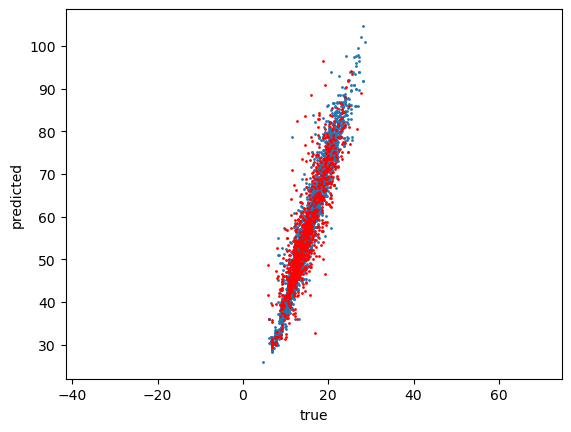

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
plt.xlabel('true')
plt.ylabel('predicted')
ax.plot(y_train, p_train2, 'o', markersize = 1)
ax.plot(y_valid, p_valid2, 'o', color="red", markersize = 1)
ax.set_xlim(0,14)
ax.set_ylim(0,14)
plt.axis('equal')

plt.show()

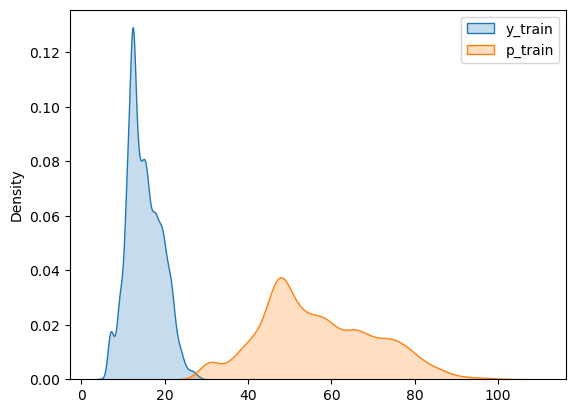

In [31]:
import seaborn as sb

fig, ax = plt.subplots()
sb.kdeplot(y_train, label='y_train', fill=True, ax=ax, bw_method=.15)
sb.kdeplot(p_train2, label='p_train', fill=True, ax=ax, bw_method=.15)

ax.legend()
plt.show()

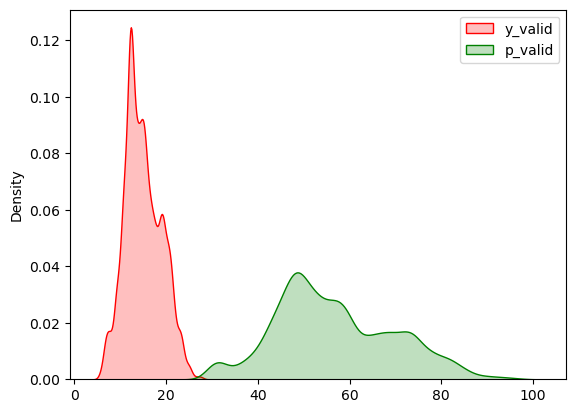

In [32]:
fig, ax = plt.subplots()
sb.kdeplot(y_valid, color = 'red', label='y_valid', fill=True, ax=ax, bw_method=.15)
sb.kdeplot(p_valid2, color = 'green', label='p_valid', fill=True, ax=ax, bw_method=.15)
ax.legend()
plt.show()